In [1]:
%matplotlib inline
import copy
import csv
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
from skimage.util import random_noise
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings

from tqdm import tqdm

warnings.filterwarnings("ignore")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 12345

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(0)

In [3]:
# import zipfile
# with zipfile.ZipFile("chest_xray_pre-processed.zip","r") as zip_ref:
#     zip_ref.extractall("chest_xray_pre-processed")

In [4]:
PATH = "chest_xray_pre-processed"

In [5]:
train_ds = ImageFolder(
    PATH + "/train",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomRotation(10),
            transforms.RandomGrayscale(),
            transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)
val_ds = ImageFolder(
    PATH + "/val",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

len(train_ds), len(val_ds)

(4257, 975)

## Adding  Noise

In [6]:
# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745/2
class AddRandomNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

## Loading the Finetuned Model

In [12]:
model = torch.load("Finetuning_Stage2.pt",map_location=device)
model.to(device);

In [13]:
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

## Explanations on Noisy Data

In [36]:
testset = ImageFolder(
    PATH + "/test",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            AddRandomNoise(0., 0.3)
        ]
    ),
)

In [37]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device);

## Explaining the Predicitons

In [38]:
import captum
import matplotlib.pyplot as plt
from captum.attr import (
    LRP,
    DeepLift,
    GuidedBackprop,
    InputXGradient,
    IntegratedGradients,
    LayerAttribution,
    LayerGradCam,
    LayerLRP,
    Occlusion,
)
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [39]:
classes = dict({0: "NORMAL", 1: "PNEUMONIA"})

## Predictions

In [40]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


from matplotlib.colors import LinearSegmentedColormap


def imshow(img, transpose=True):
    plt.figure(figsize=(11, 6))
    x = img.cpu() * STD[:, None, None] + MEAN[:, None, None]
    # img = img / 2 + 0.5     # unnormalize
    npimg = x.cpu().numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()

In [41]:
def pred_image(index):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    images = images.to(device)
    labels = labels.to(device)
    ind = index
    input = images[ind].unsqueeze(0)
    input.requires_grad = True

    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = classes[pred_label_idx.item()]
    # imshow(images[ind])
    print("Index:", ind)
    print("Ground Truth:", classes[labels[ind].item()])
    print("Predicted:", predicted_label, "(", prediction_score.squeeze().item(), ")")
    return input, pred_label_idx

# 1. Integrated Gradients

In [42]:
input, pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.669217586517334 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


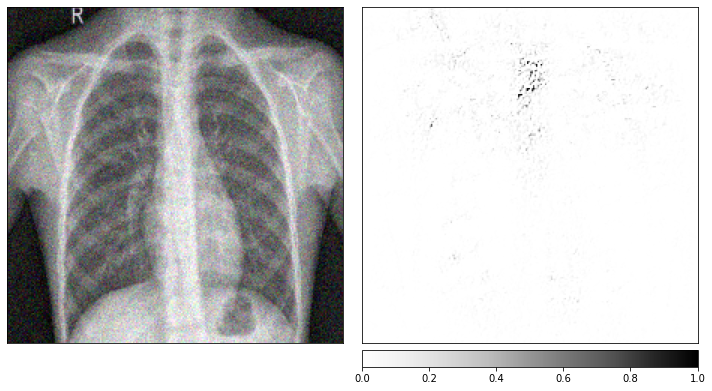

In [43]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(
    input, target=pred_label_idx, n_steps=50
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

In [44]:
input, pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.5458245873451233 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


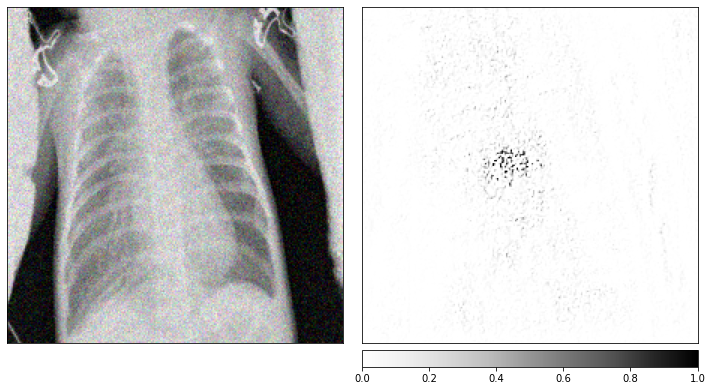

In [45]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

attributions_ig = integrated_gradients.attribute(
    input, target=pred_label_idx, n_steps=50
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

# 2. Input X Gradient

In [46]:
input, pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.7001456618309021 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


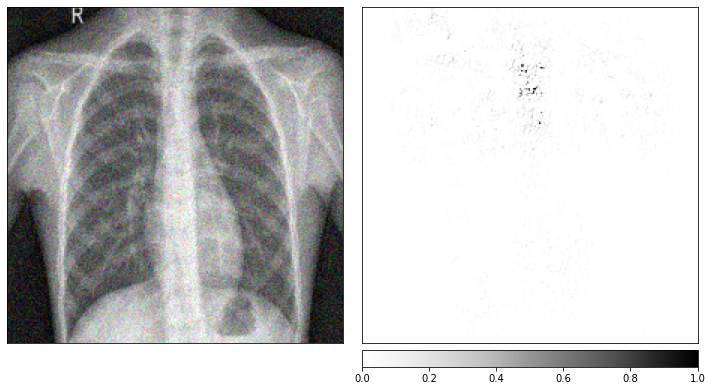

In [47]:
input_x_gradient = InputXGradient(model)
attribution_ixg = input_x_gradient.attribute(input, target=0)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attribution_ixg.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .cpu()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

In [48]:
input, pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.5603890419006348 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


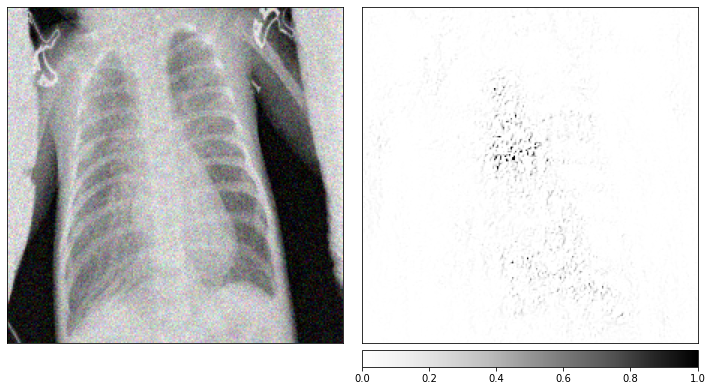

In [49]:
input_x_gradient = InputXGradient(model)
attribution_ixg = input_x_gradient.attribute(input, target=0)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attribution_ixg.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .cpu()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

# 3. Occlusion

In [50]:
input, pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.699695348739624 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


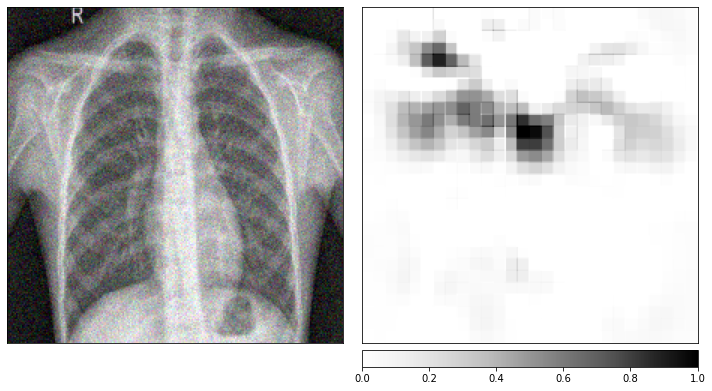

In [51]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    input,
    target=pred_label_idx,
    strides=(3, 8, 8),
    sliding_window_shapes=(3, 15, 15),
    baselines=0,
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .cpu()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

In [52]:
input, pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.5659539699554443 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


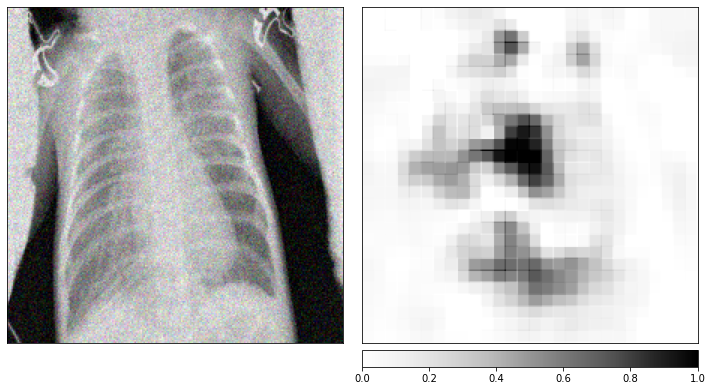

In [53]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    input,
    target=pred_label_idx,
    strides=(3, 8, 8),
    sliding_window_shapes=(3, 15, 15),
    baselines=0,
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .cpu()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

# 4. LRP- Layer-wise relevance propagation


In [54]:
input, pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.6869065165519714 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


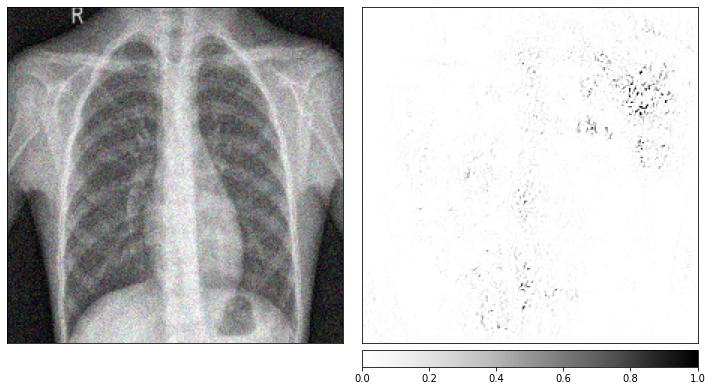

In [55]:
lrp = LRP(model)
attribution_lrp = lrp.attribute(input, target=0, verbose=False)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attribution_lrp.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .cpu()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.5453006029129028 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


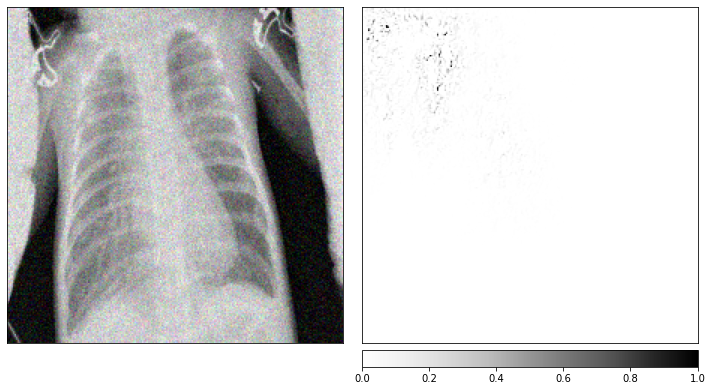

In [56]:
input, pred_label_idx = pred_image(255)

lrp = LRP(model)
attribution_lrp = lrp.attribute(input, target=0, verbose=False)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attribution_lrp.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(
        (input.cpu() * STD[:, None, None] + MEAN[:, None, None])
        .squeeze()
        .cpu()
        .detach()
        .numpy(),
        (1, 2, 0),
    ),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    fig_size=(10, 8),
    cmap="Greys",
)